# Business Problem

Cookie Cats is a hugely popular mobile puzzle game developed by Tactile Entertainment. It's a classic "connect three" style puzzle game where the player must connect tiles of the same color in order to clear the board and win the level. It also features singing cats. We're not kidding!

As players progress through the game they will encounter gates that force them to wait some time before they can progress or make an in-app purchase. In this project, we will analyze the result of an A/B test where the first gate in Cookie Cats was moved from level 30 to level 40. In particular, we will analyze the impact on player retention.

<center><iframe width="560" height="315" src="https://www.datacamp.com/projects/184" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe></iframe></center>


### Data Description from (https://www.datacamp.com/projects/184)

<p>The data is from 90,189 players that installed the game while the AB-test was running. The variables are:</p>
<ul>
<li><code>userid</code> - a unique number that identifies each player.</li>
<li><code>version</code> - whether the player was put in the control group (<code>gate_30</code> - a gate at level 30) or the test group (<code>gate_40</code> - a gate at level 40).</li>
<li><code>sum_gamerounds</code> - the number of game rounds played by the player during the first week after installation
<li><code>retention_1</code> - did the player come back and play 1 day after installing?</li>
<li><code>retention_7</code> - did the player come back and play 7 days after installing?</li>
</ul>
<p>When a player installed the game, he or she was randomly assigned to either <code>gate_30</code> or <code>gate_40</code>. </p>

# 0.0 Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency

## 0.1 Load Data

In [2]:
path = 'C:/Users/edils/repos/teste_ab/data/'

df_raw = pd.read_csv(path + 'cookie_cats.csv')

In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


# 1.0 Data Understanding

In [31]:
df1 = df_raw.copy()

In [32]:
df1.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


## 1.1 Check Homogeinity

In [40]:
df1.groupby('version').agg({
        'version':['count'],
        'sum_gamerounds':['min','max','mean','std'],
        'retention_1':['count'],
        'retention_7':['count']
    
}).reset_index()


version        sum_gamerounds                              retention_1  \
            count            min   max       mean         std       count   
0  gate_30  42762              1  2961  53.667766  103.743691       42762   
1  gate_40  43432              1  2640  53.728357  105.093012       43432   

  retention_7  
        count  
0       42762  
1       43432

There is a strange value on sum_gamerounds max value, I will investigate with a boxplot.

## 1.2 Check Outliers

<Axes: >

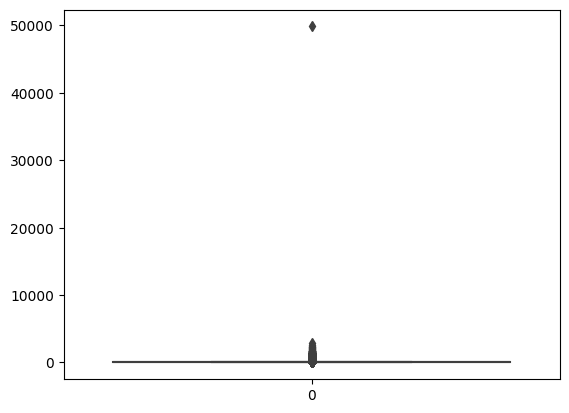

In [34]:
sns.boxplot(df1['sum_gamerounds'])

We have an outlier with sum_gamerounds = 49854. Let's remove it.

In [35]:
df1 = df1.loc[df1['sum_gamerounds'] != 49854,:]

## 1.3 Check Na / Zeros

In [36]:
# Criar uma tabela de frequência para sum_gamerounds
game_rounds = df1['sum_gamerounds'].value_counts(normalize=True).reset_index()
game_rounds.columns = ['sum_gamerounds', 'percentage']

# Exibir a distribuição de porcentagem de sum_gamerounds
print(game_rounds)

     sum_gamerounds  percentage
0                 1    0.061405
1                 2    0.051071
2                 0    0.044285
3                 3    0.043886
4                 4    0.040238
..              ...         ...
936             933    0.000011
937             617    0.000011
938            1462    0.000011
939             578    0.000011
940             708    0.000011

[941 rows x 2 columns]


About 4% of my customers did not play the game (0 Game Rounds). Let's remove them.

In [37]:
df1 = df1.loc[df1['sum_gamerounds'] != 0,:]

In [45]:
df1.isna().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

## 1.4 Distribuition

<Axes: xlabel='sum_gamerounds', ylabel='Count'>

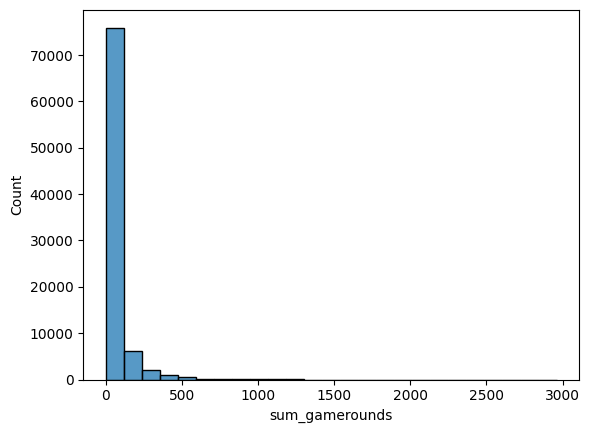

In [39]:
sns.histplot(df1['sum_gamerounds'], bins=25)

## 1.5 Check for Bad Users(both Group and Control at the same time)

In [44]:
# Check if There's same user for both group and treatment
df1[['version','userid']].groupby('userid').nunique().query('version > 1').reset_index()

,userid,version


# 2.0 Experiment Design

--- 

# Objective

Analyze customer retention by moving the gate to level 30 to level 40.

 - Gate 30 = Control Group
 - Gate 40 = Treatment Group

 - H0: Moving the gate does not increase retention
 - H1: Moving the gate increase retention
 
 - Significance Level: 0.05

## 2.1 Sample Size

In [9]:
pd.crosstab(df1['version'], df1['retention_1'])

retention_1,False,True
version,,
gate_30,24665,20034
gate_40,25370,20119


## 2.2 Chi-Squared Test

### 2.2.1 Test for 1 Day Retention

In [10]:
# Create contingency table for retention_1
contingency_table_1 = pd.crosstab(df1['version'], df1['retention_1'])

# Chi-squared test for retention_1
chi2_stat_1, p_value_1, dof_1, expected_1 = chi2_contingency(contingency_table_1)

# Results for retention_1
print("Retention 1-day:")
print(f"Chi-squared Statistic: {chi2_stat_1}")
print(f"P-value: {p_value_1}")
print(f"Degrees of Freedom: {dof_1}")
print("Contingency Table:")
print(contingency_table_1)
print("Expected Frequencies:")
print(expected_1)

Retention 1-day:
Chi-squared Statistic: 3.169835543170799
P-value: 0.07500999897705692
Degrees of Freedom: 1
Contingency Table:
retention_1  False  True 
version                  
gate_30      24665  20034
gate_40      25370  20119
Expected Frequencies:
[[24798.35970417 19900.64029583]
 [25236.64029583 20252.35970417]]


---

# Retention After 1 day playing:

### P-value: 0.075 (greater than 0.05)

Conclusion: There is **not sufficient statistical** evidence to reject the null hypothesis. This suggests that, based on the observed data, there is no significant association between the game version (gate_30 or gate_40) and player retention after 1 day. This might happens because the player had no time to get to gate 30/40 in the first day playing.

In [11]:
contingency_table_7 = pd.crosstab(df1['version'], df1['retention_7'])


chi2_stat_7, p_value_7, dof_7, expected_7 = chi2_contingency(contingency_table_7)

# Results for retention_7
print("Retention 7-day:")
print(f"Chi-squared Statistic: {chi2_stat_7}")
print(f"P-value: {p_value_7}")
print(f"Degrees of Freedom: {dof_7}")
print("Contingency Table:")
print(contingency_table_7)
print("Expected Frequencies:")
print(expected_7)

Retention 7-day:
Chi-squared Statistic: 9.91527552890567
P-value: 0.0016391259678654425
Degrees of Freedom: 1
Contingency Table:
retention_7  False  True 
version                  
gate_30      36198   8501
gate_40      37210   8279
Expected Frequencies:
[[36382.49203885  8316.50796115]
 [37025.50796115  8463.49203885]]


### 2.2.2 Test for 7 days Retention

---

# Retention After 7 days playing:

### P-Value: P-value: 0.0016 (less than 0.05) 

Conclusion: Based on the observed data, **there is statistical evidence to reject the null hypothesis.** This suggests that a **significant association exists** between the game version and player retention after 7 days.